# 📊 Stage 2: Exploratory Data Analysis (EDA) - Finding Data "Traps"

## 🎯 Core Objective
**Not just simple visualization, but "trap finding"!**

Unlike conventional EDA, the core objective of this stage is:
- **Bias Detection**: Identify sample distribution issues that may lead to unfair models
- **Simpson's Paradox**: Discover statistical traps where overall trends contradict stratified trends
- **Hidden Correlations**: Find feature relationships that may lead to multicollinearity

## 🤔 Why Do We Need Dedicated "Trap Detection"?

### Common Data Traps and Their Consequences:

| Trap Type | Specific Manifestation | What Happens If Not Addressed? |
|---------|---------|------------------|
| **Sample Bias** | Extreme gender/racial sample imbalance | Model has very low prediction accuracy for minority groups, producing discriminatory results |
| **Simpson's Paradox** | Overall trend contradicts stratified trends | Model decision logic conflicts with actual causal relationships, leading to incorrect conclusions |
| **Class Imbalance** | High-income samples only account for 25% | Model always predicting "low income" can still achieve 75% accuracy (false high score) |
| **Feature Multicollinearity** | Years of education highly correlated with degree level | Model coefficients are unstable, unable to explain true feature impact |

## 📋 Analysis Flow of This Notebook

```
Data Loading
   ↓
Bias Analysis (Section 2)
   ├─ Demographic distribution check (gender, race, nationality)
   ├─ Visualize imbalance levels
   └─ Cross-analysis: Gender × Income (detect income gap)
   ↓
Simpson's Paradox Detection (Section 3)
   ├─ Overall: Education level vs Income
   ├─ Stratified: Education × Gender × Income
   └─ Compare if trends reverse
   ↓
Feature Correlation Analysis (Section 4)
   ├─ Numerical feature correlation matrix
   └─ Key feature distribution comparison
   ↓
Categorical Feature Analysis (Section 5-6)
   ├─ Work class vs Income
   └─ Age groups vs Income
   ↓
Data Quality Report (Section 7-8)
   └─ Generate issue list to guide subsequent governance
```

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
sns.set_style('whitegrid')
sns.set_palette('Set2')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

In [2]:
data_path = '../data/raw/adult.csv'
df = pd.read_csv(data_path)

df_clean = df.replace('?', np.nan)

print(f"Dataset shape: {df.shape}")
print(f"Target variable classes: {df['income'].unique()}")
display(df.head())

Dataset shape: (32561, 15)
Target variable classes: <StringArray>
['<=50K', '>50K']
Length: 2, dtype: str


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## 2. Bias Detection Analysis

### 2.1 Distribution Imbalance in Demographic Features

In [3]:
demographic_features = ['sex', 'race', 'native.country']

print("=== Demographic Distribution Analysis ===")
for feature in demographic_features:
    if feature in df.columns:
        print(f"\n{feature.upper()} Distribution:")
        value_counts = df[feature].value_counts()
        value_percentages = (value_counts / len(df) * 100).round(2)
        distribution = pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_percentages
        })
        display(distribution.head(10))

=== Demographic Distribution Analysis ===

SEX Distribution:


,Count,Percentage
sex,,
Male,21790,66.92
Female,10771,33.08



RACE Distribution:


,Count,Percentage
race,,
White,27816,85.43
Black,3124,9.59
Asian-Pac-Islander,1039,3.19
Amer-Indian-Eskimo,311,0.96
Other,271,0.83



NATIVE.COUNTRY Distribution:


,Count,Percentage
native.country,,
United-States,29170,89.59
Mexico,643,1.97
?,583,1.79
Philippines,198,0.61
Germany,137,0.42
Canada,121,0.37
Puerto-Rico,114,0.35
El-Salvador,106,0.33
India,100,0.31


### 2.2 Visualization of Gender and Race Sample Sizes

📊 **Chart Description:**
- Left chart: Gender distribution bar chart showing male/female sample counts
- Right chart: Race distribution bar chart showing sample counts by race
- Focus: Check for **Demographic Bias** - if one gender or race accounts for more than 70%, it indicates insufficient data representativeness, which may lead to poor model performance on minority groups

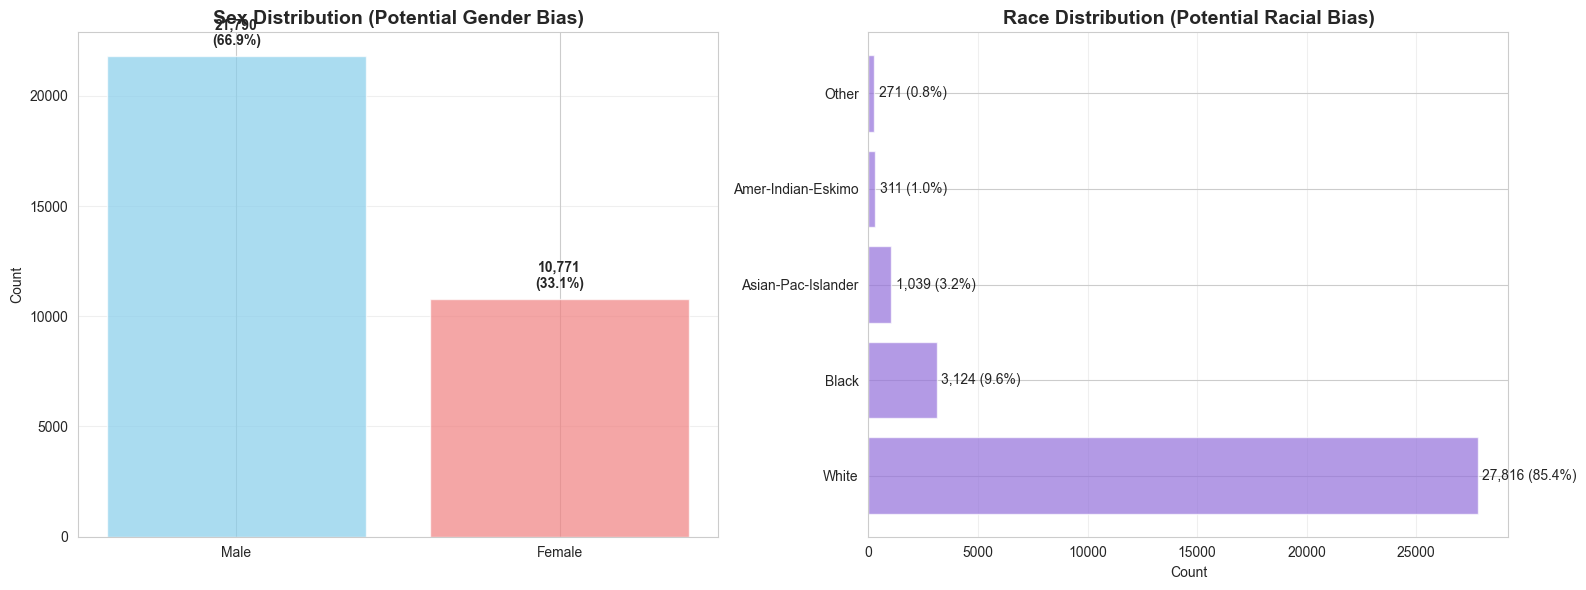


⚠️ BIAS WARNING:
   - Gender: 66.9% Male vs 33.1% Female - Significant imbalance!
   - Race: 85.4% White - Potential racial bias in sampling!


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if 'sex' in df.columns:
    sex_counts = df['sex'].value_counts()
    axes[0].bar(sex_counts.index, sex_counts.values, color=['skyblue', 'lightcoral'], alpha=0.7)
    axes[0].set_title('Sex Distribution (Potential Gender Bias)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(sex_counts.values):
        axes[0].text(i, v + 500, f'{v:,}\n({v/len(df)*100:.1f}%)', ha='center', fontweight='bold')

if 'race' in df.columns:
    race_counts = df['race'].value_counts()
    axes[1].barh(race_counts.index, race_counts.values, color='mediumpurple', alpha=0.7)
    axes[1].set_title('Race Distribution (Potential Racial Bias)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Count')
    axes[1].grid(axis='x', alpha=0.3)
    for i, v in enumerate(race_counts.values):
        axes[1].text(v + 200, i, f'{v:,} ({v/len(df)*100:.1f}%)', va='center')

plt.tight_layout()
plt.savefig('../outputs/figures/02_demographic_bias.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n⚠️ BIAS WARNING:")
if 'sex' in df.columns:
    male_ratio = (df['sex'] == 'Male').sum() / len(df) * 100
    print(f"   - Gender: {male_ratio:.1f}% Male vs {100-male_ratio:.1f}% Female - Significant imbalance!")
if 'race' in df.columns:
    white_ratio = (df['race'] == 'White').sum() / len(df) * 100
    print(f"   - Race: {white_ratio:.1f}% White - Potential racial bias in sampling!")

### 2.3 Cross-Analysis: Gender × Income

📊 **Chart Description:**
- Stacked bar chart showing proportion distribution of males/females across two income classes
- Focus: Check for **Gender Income Gap** - if male high-income proportion is significantly higher than female (e.g., 20% vs 10%), it indicates gender bias risk

=== Sex vs Income (% within each gender) ===


income,<=50K,>50K
sex,,
Female,89.05,10.95
Male,69.43,30.57


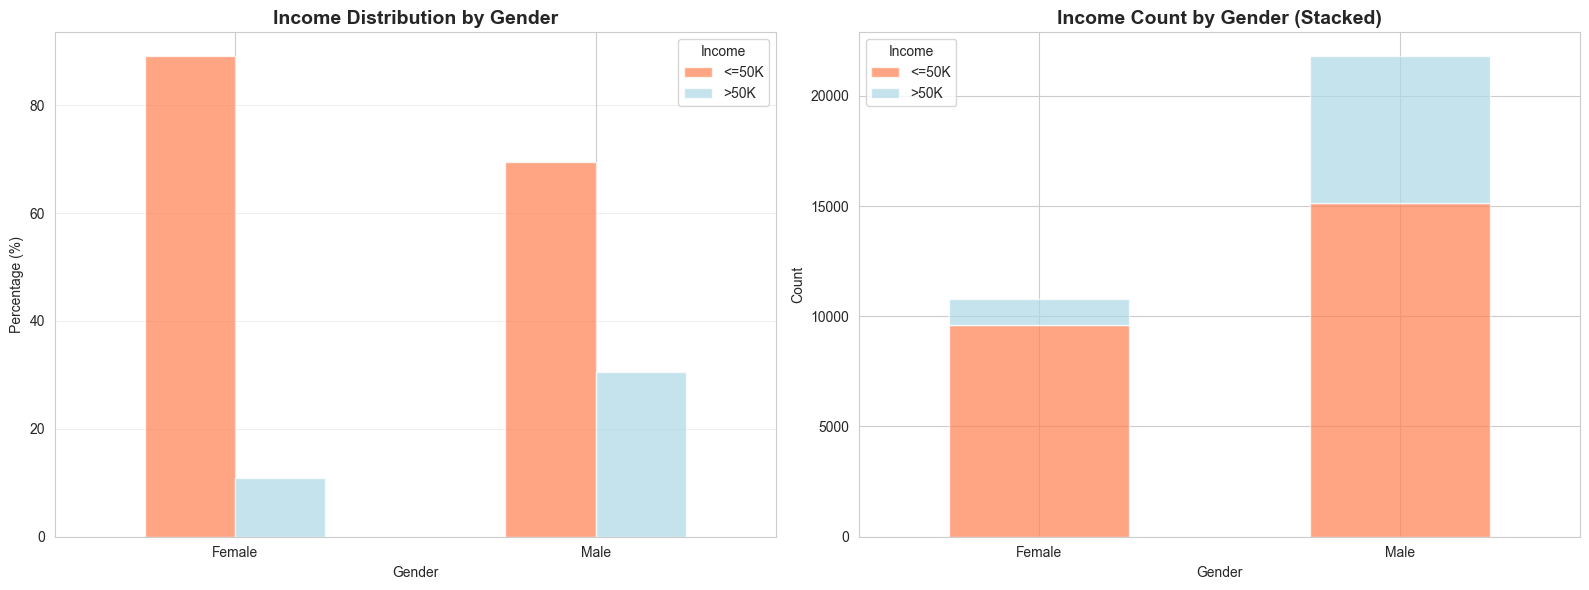


💡 KEY INSIGHT:
   - Male high-income rate: 30.6%
   - Female high-income rate: 10.9%
   - Gender income gap: 19.6 percentage points


In [5]:
if 'sex' in df.columns and 'income' in df.columns:
    sex_income = pd.crosstab(df['sex'], df['income'], normalize='index') * 100
    
    print("=== Sex vs Income (% within each gender) ===")
    display(sex_income.round(2))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sex_income.plot(kind='bar', ax=axes[0], color=['coral', 'lightblue'], alpha=0.7)
    axes[0].set_title('Income Distribution by Gender', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_xlabel('Gender')
    axes[0].legend(title='Income')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=0)
    
    sex_income_counts = pd.crosstab(df['sex'], df['income'])
    sex_income_counts.plot(kind='bar', stacked=True, ax=axes[1], color=['coral', 'lightblue'], alpha=0.7)
    axes[1].set_title('Income Count by Gender (Stacked)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Count')
    axes[1].set_xlabel('Gender')
    axes[1].legend(title='Income')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_sex_income_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💡 KEY INSIGHT:")
    if '>50K' in sex_income.columns:
        male_high = sex_income.loc['Male', '>50K'] if 'Male' in sex_income.index else 0
        female_high = sex_income.loc['Female', '>50K'] if 'Female' in sex_income.index else 0
        print(f"   - Male high-income rate: {male_high:.1f}%")
        print(f"   - Female high-income rate: {female_high:.1f}%")
        print(f"   - Gender income gap: {male_high - female_high:.1f} percentage points")

### 2.4 Cross-Analysis: Race × Income

📊 **Chart Description:**
- Stacked bar chart showing proportion distribution of each race across two income classes
- Focus: Check for **Racial Income Gap** - if high-income proportion gap between races exceeds 10 percentage points, be alert to racial bias

=== Race vs Income (% within each race) ===


income,<=50K,>50K
race,,
Amer-Indian-Eskimo,88.42,11.58
Asian-Pac-Islander,73.44,26.56
Black,87.61,12.39
Other,90.77,9.23
White,74.41,25.59


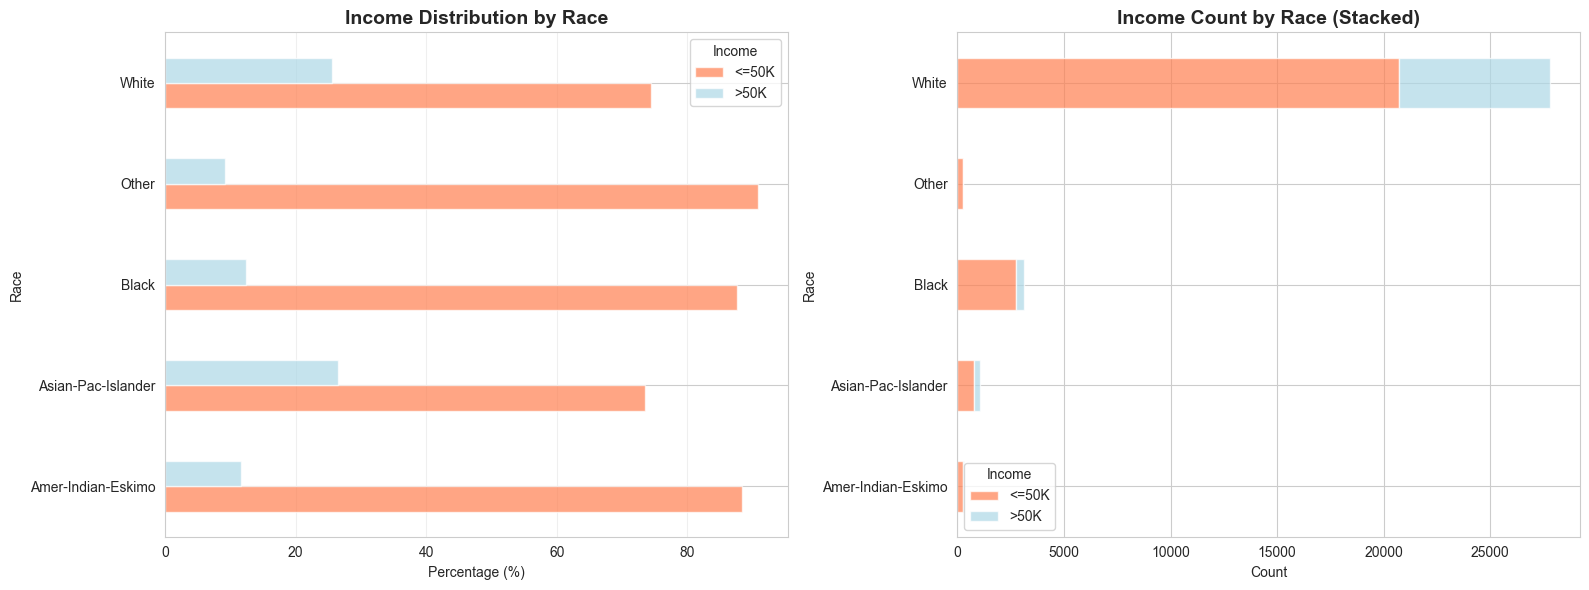


💡 KEY INSIGHT:
   - Amer-Indian-Eskimo: 11.6% high-income rate
   - Asian-Pac-Islander: 26.6% high-income rate
   - Black: 12.4% high-income rate
   - Other: 9.2% high-income rate
   - White: 25.6% high-income rate

   ⚠️ Racial income gap: 17.3 percentage points
   (Between highest: Asian-Pac-Islander and lowest: Other)


In [6]:
if 'race' in df.columns and 'income' in df.columns:
    race_income = pd.crosstab(df['race'], df['income'], normalize='index') * 100
    
    print("=== Race vs Income (% within each race) ===")
    display(race_income.round(2))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Horizontal bar chart for better label readability
    race_income.plot(kind='barh', ax=axes[0], color=['coral', 'lightblue'], alpha=0.7)
    axes[0].set_title('Income Distribution by Race', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Percentage (%)')
    axes[0].set_ylabel('Race')
    axes[0].legend(title='Income')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Stacked count
    race_income_counts = pd.crosstab(df['race'], df['income'])
    race_income_counts.plot(kind='barh', stacked=True, ax=axes[1], 
                           color=['coral', 'lightblue'], alpha=0.7)
    axes[1].set_title('Income Count by Race (Stacked)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('Race')
    axes[1].legend(title='Income')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_race_income_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n💡 KEY INSIGHT:")
    if '>50K' in race_income.columns:
        for race in race_income.index:
            high_income_rate = race_income.loc[race, '>50K']
            print(f"   - {race}: {high_income_rate:.1f}% high-income rate")
        
        # Calculate racial income gap
        max_rate = race_income['>50K'].max()
        min_rate = race_income['>50K'].min()
        max_race = race_income['>50K'].idxmax()
        min_race = race_income['>50K'].idxmin()
        print(f"\n   ⚠️ Racial income gap: {max_rate - min_rate:.1f} percentage points")
        print(f"   (Between highest: {max_race} and lowest: {min_race})")

## 3. Simpson's Paradox Detection

### 3.1 Overall Relationship Between Education Level and Income

📊 **Chart Description:**
- Bar chart showing high-income proportion (>50K) for different education levels
- Focus: Verify if the common sense "higher education level, higher income" holds, providing an overall baseline for subsequent Simpson's Paradox detection

=== Overall: Education vs Income ===


income,<=50K,>50K
education,,
Doctorate,25.91,74.09
Prof-school,26.56,73.44
Masters,44.34,55.66
Bachelors,58.52,41.48
Assoc-voc,73.88,26.12
Assoc-acdm,75.16,24.84
Some-college,80.98,19.02
HS-grad,84.05,15.95
12th,92.38,7.62


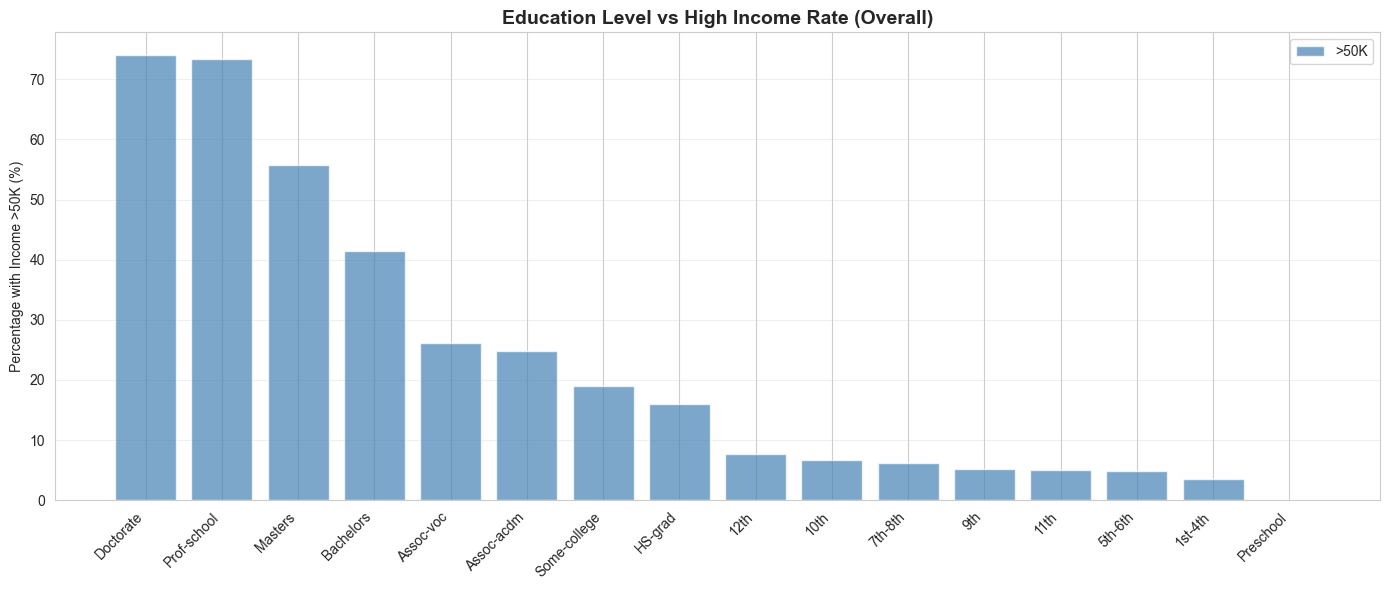

In [7]:
if 'education' in df.columns and 'income' in df.columns:
    edu_income = pd.crosstab(df['education'], df['income'], normalize='index') * 100
    edu_income_sorted = edu_income.sort_values('>50K', ascending=False)
    
    print("=== Overall: Education vs Income ===")
    display(edu_income_sorted.round(2))
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(edu_income_sorted))
    ax.bar(x, edu_income_sorted['>50K'], color='steelblue', alpha=0.7, label='>50K')
    ax.set_xticks(x)
    ax.set_xticklabels(edu_income_sorted.index, rotation=45, ha='right')
    ax.set_ylabel('Percentage with Income >50K (%)')
    ax.set_title('Education Level vs High Income Rate (Overall)', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_education_income_overall.png', dpi=300, bbox_inches='tight')
    plt.show()

### 3.2 Detecting Simpson's Paradox: Education × Gender × Income

📊 **Chart Description:**
- Comparison chart showing high-income proportion for males/females at the same education level
- Focus: Detect **Simpson's Paradox** - a phenomenon where overall trends contradict grouped trends, e.g., education and income are positively correlated overall, but reversal may occur when grouped by gender

=== Simpson's Paradox Detection: Education × Sex × Income ===


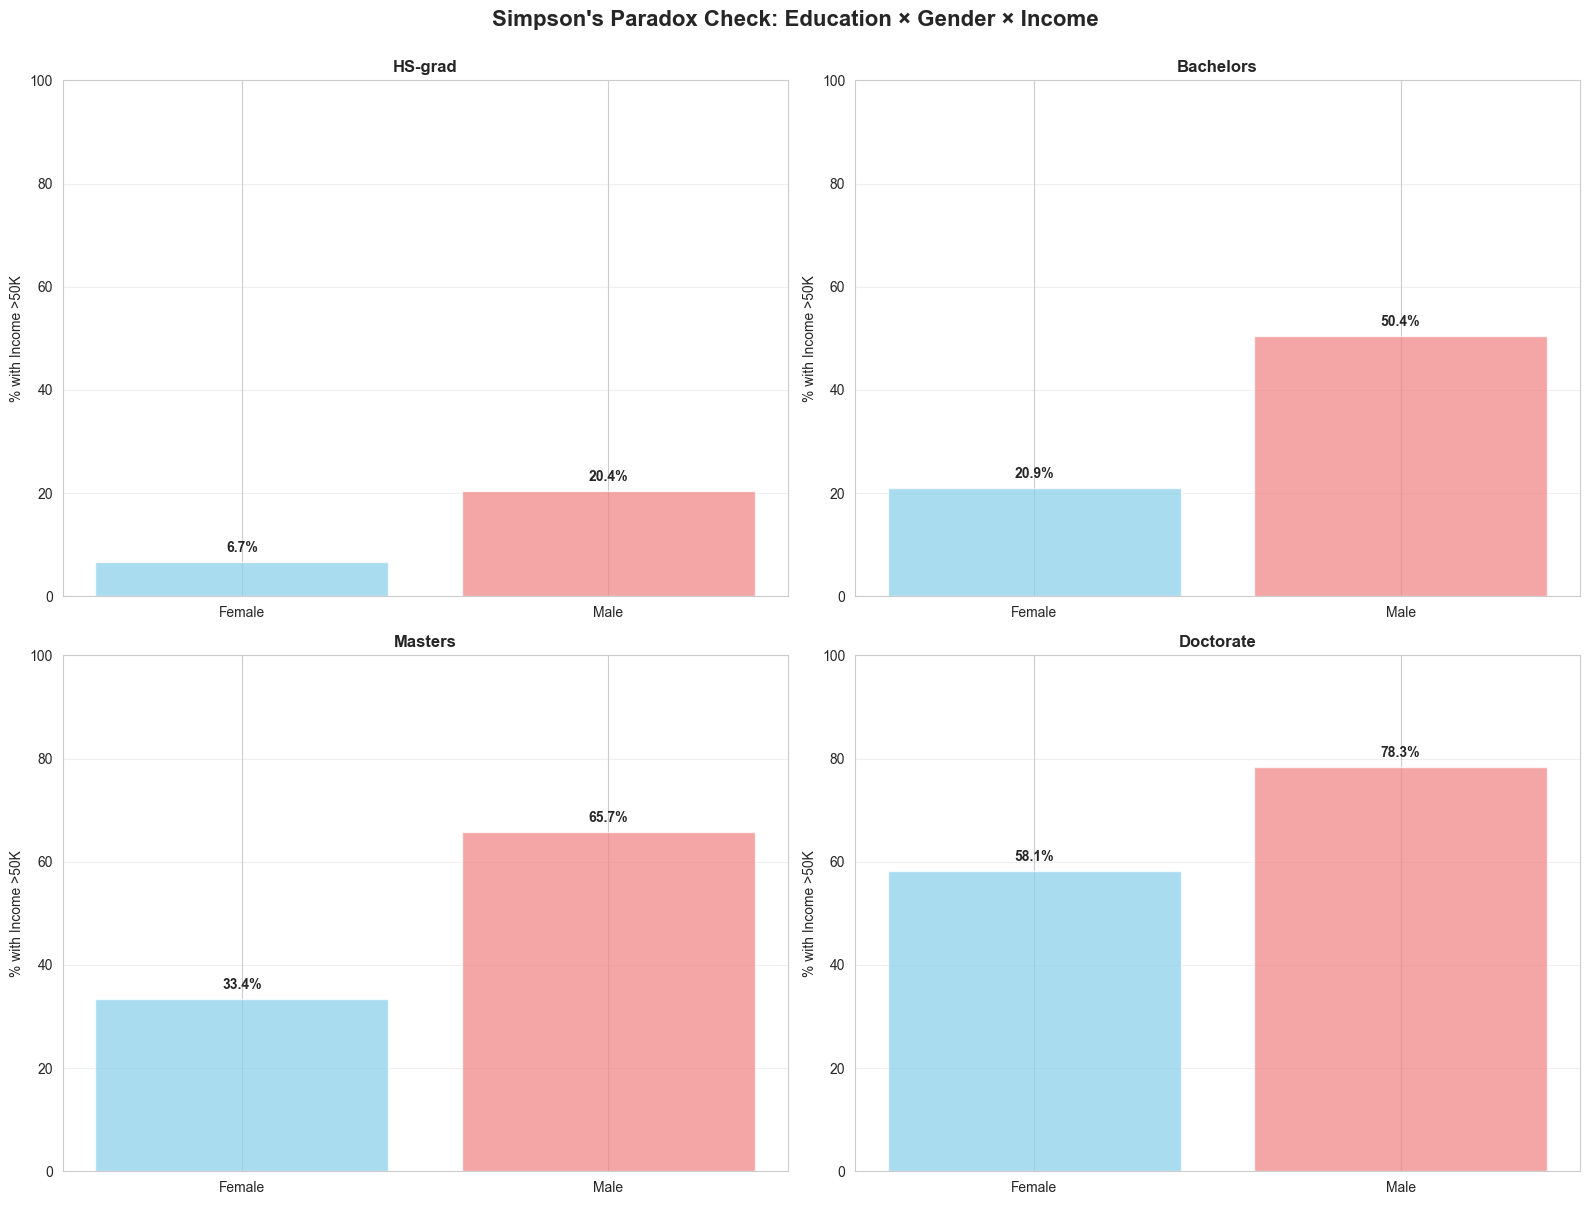


🔍 SIMPSON'S PARADOX ANALYSIS:
   Compare patterns within each education level vs overall trend.
   If gender income gap direction reverses across education levels,
   this indicates Simpson's Paradox!


In [8]:
if all(col in df.columns for col in ['education', 'sex', 'income']):
    print("=== Simpson's Paradox Detection: Education × Sex × Income ===")
    
    edu_sex_income = df.groupby(['education', 'sex', 'income']).size().unstack(fill_value=0)
    edu_sex_income_pct = edu_sex_income.div(edu_sex_income.sum(axis=1), axis=0) * 100
    
    education_levels = ['HS-grad', 'Bachelors', 'Masters', 'Doctorate']
    available_edu = [edu for edu in education_levels if edu in df['education'].unique()]
    
    if len(available_edu) > 0 and '>50K' in edu_sex_income_pct.columns:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for idx, edu in enumerate(available_edu[:4]):
            if edu in edu_sex_income_pct.index.get_level_values(0):
                data = edu_sex_income_pct.loc[edu, '>50K']
                if isinstance(data, pd.Series):
                    axes[idx].bar(data.index, data.values, color=['skyblue', 'lightcoral'], alpha=0.7)
                    axes[idx].set_title(f'{edu}', fontsize=12, fontweight='bold')
                    axes[idx].set_ylabel('% with Income >50K')
                    axes[idx].grid(axis='y', alpha=0.3)
                    axes[idx].set_ylim(0, 100)
                    
                    for i, v in enumerate(data.values):
                        axes[idx].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
        
        plt.suptitle('Simpson\'s Paradox Check: Education × Gender × Income', 
                     fontsize=16, fontweight='bold', y=1.00)
        plt.tight_layout()
        plt.savefig('../outputs/figures/02_simpsons_paradox.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n🔍 SIMPSON'S PARADOX ANALYSIS:")
        print("   Compare patterns within each education level vs overall trend.")
        print("   If gender income gap direction reverses across education levels,")
        print("   this indicates Simpson's Paradox!")

## 4. Feature Correlation Analysis

### 4.1 Correlation Matrix of Numerical Features

📊 **Chart Description:**
- Heatmap showing correlation coefficients (-1 to 1) between all numerical features
- Focus: Identify **highly correlated features (|r|>0.8)** - these features may have multicollinearity and should be considered for removal or combination during feature engineering

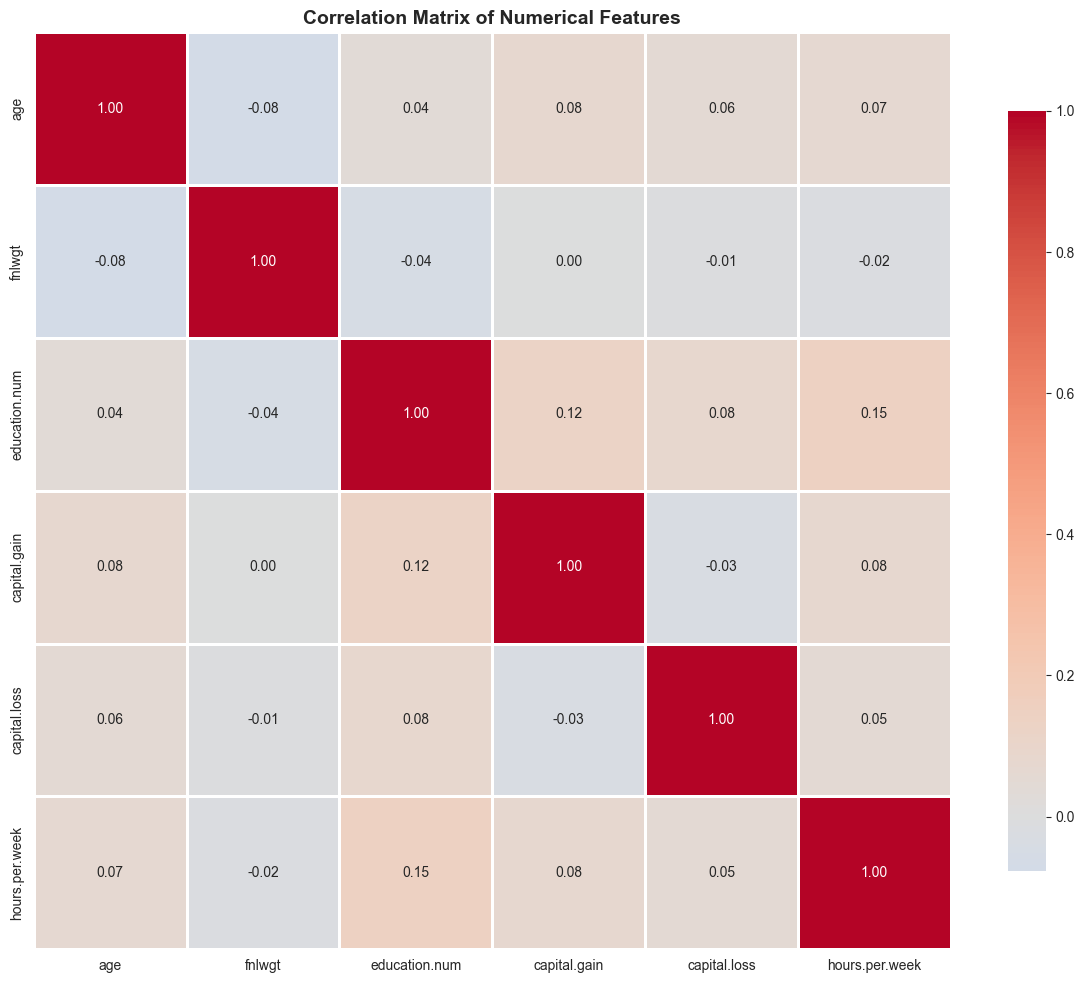


=== High Correlations (|r| > 0.5) ===
No high correlations found.


In [9]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if len(numerical_cols) > 0:
    correlation_matrix = df[numerical_cols].corr()
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n=== High Correlations (|r| > 0.5) ===")
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.5:
                high_corr.append({
                    'Feature 1': correlation_matrix.columns[i],
                    'Feature 2': correlation_matrix.columns[j],
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    if high_corr:
        display(pd.DataFrame(high_corr))
    else:
        print("No high correlations found.")

### 4.2 Relationship Between Key Features and Income

📊 **Chart Description:**
- Violin plot showing distribution shapes of 4 key numerical features across different income classes
- Focus: Observe the **overlap degree** of distributions between two income classes - less overlap indicates stronger discriminative power of the feature, making it an important modeling feature

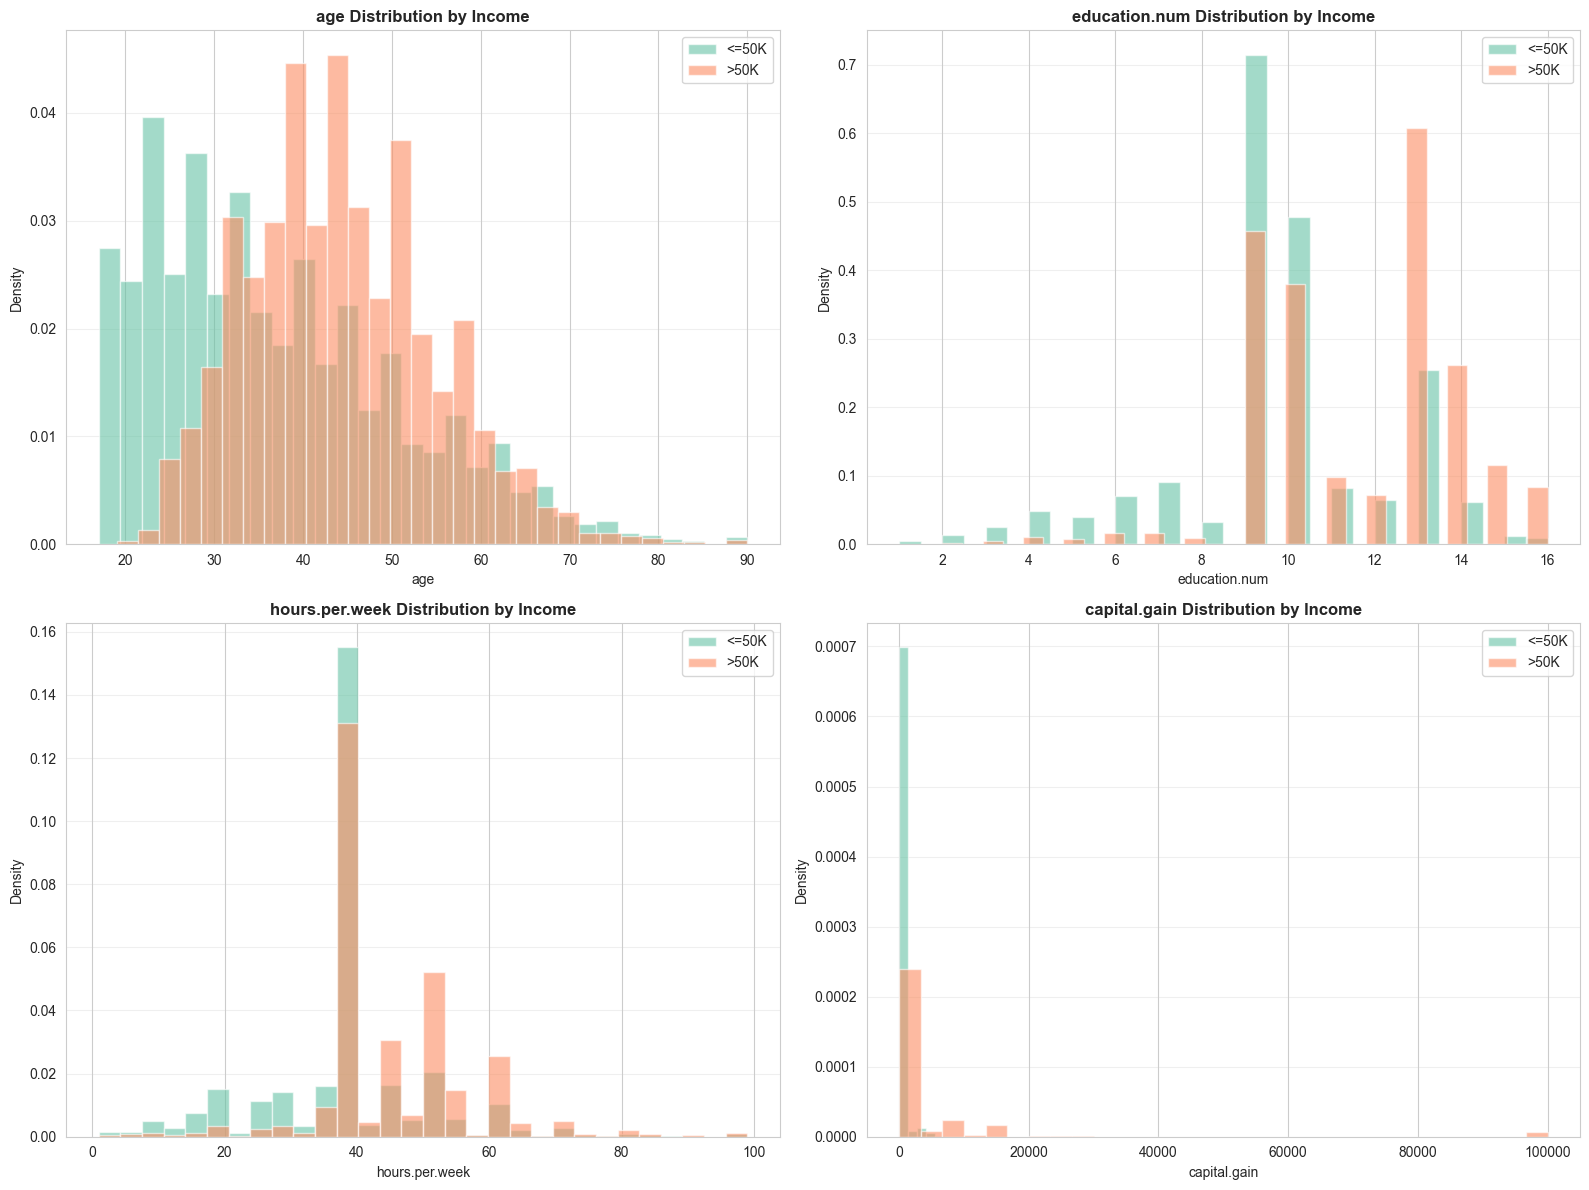

In [10]:
key_features = ['age', 'education.num', 'hours.per.week', 'capital.gain']
available_features = [f for f in key_features if f in df.columns]

if len(available_features) > 0 and 'income' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, feature in enumerate(available_features[:4]):
        for income_class in df['income'].unique():
            data = df[df['income'] == income_class][feature].dropna()
            axes[idx].hist(data, bins=30, alpha=0.6, label=income_class, density=True)
        
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel('Density')
        axes[idx].set_title(f'{feature} Distribution by Income', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_features_vs_income.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Work Class and Occupation Analysis

📊 **Chart Description:**
- Stacked bar chart showing income distribution for different work classes (e.g., government, private, self-employed)
- Focus: Identify which work classes are strongly correlated with high income, and check for data quality issues (e.g., insufficient samples in certain categories)

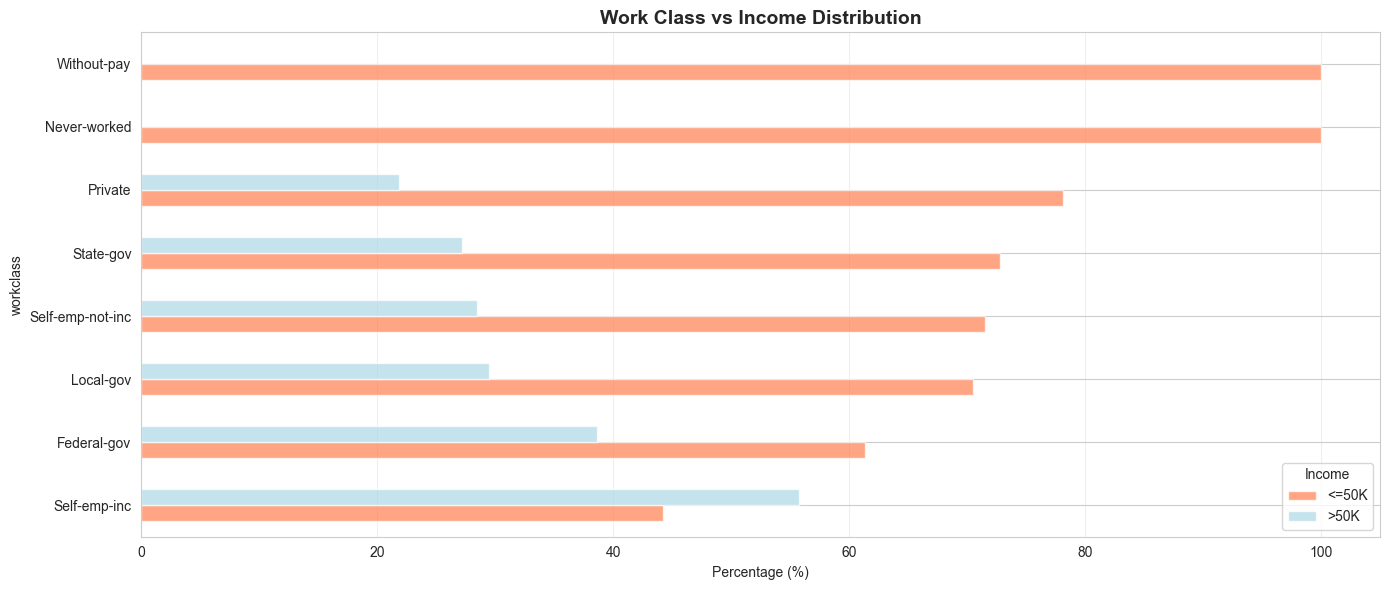


=== Work Class High-Income Rates ===


workclass
Self-emp-inc        55.73
Federal-gov         38.65
Local-gov           29.48
Self-emp-not-inc    28.49
State-gov           27.20
Private             21.87
Never-worked         0.00
Without-pay          0.00
Name: >50K, dtype: float64

In [11]:
if 'workclass' in df.columns and 'income' in df.columns:
    workclass_clean = df_clean.dropna(subset=['workclass', 'income'])
    
    workclass_income = pd.crosstab(workclass_clean['workclass'], 
                                   workclass_clean['income'], 
                                   normalize='index') * 100
    
    if '>50K' in workclass_income.columns:
        workclass_income_sorted = workclass_income.sort_values('>50K', ascending=False)
        
        fig, ax = plt.subplots(figsize=(14, 6))
        workclass_income_sorted.plot(kind='barh', stacked=False, ax=ax, 
                                     color=['coral', 'lightblue'], alpha=0.7)
        ax.set_xlabel('Percentage (%)')
        ax.set_title('Work Class vs Income Distribution', fontsize=14, fontweight='bold')
        ax.legend(title='Income', loc='lower right')
        ax.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../outputs/figures/02_workclass_income.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("\n=== Work Class High-Income Rates ===")
        display(workclass_income_sorted['>50K'].sort_values(ascending=False).round(2))

## 6. Age Distribution and Income Relationship

📊 **Chart Description:**
- Grouped bar chart showing high-income proportion for different age groups (<25, 25-35, 35-45, etc.)
- Focus: Verify the hypothesis "age is positively correlated with income", identify peak income age groups, providing basis for feature engineering (e.g., age binning)

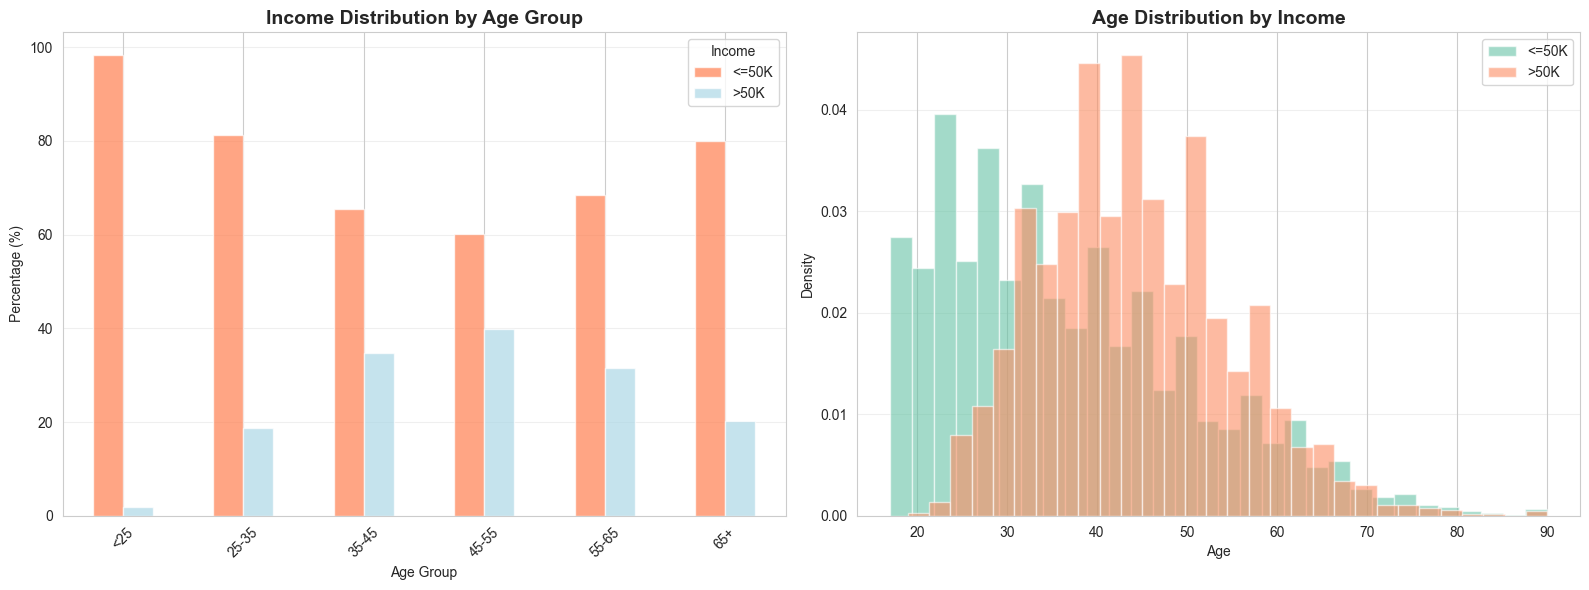

In [12]:
if 'age' in df.columns and 'income' in df.columns:
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100],
                             labels=['<25', '25-35', '35-45', '45-55', '55-65', '65+'])
    
    age_income = pd.crosstab(df['age_group'], df['income'], normalize='index') * 100
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    age_income.plot(kind='bar', ax=axes[0], color=['coral', 'lightblue'], alpha=0.7)
    axes[0].set_title('Income Distribution by Age Group', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)')
    axes[0].set_xlabel('Age Group')
    axes[0].legend(title='Income')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    for income_class in df['income'].unique():
        data = df[df['income'] == income_class]['age'].dropna()
        axes[1].hist(data, bins=30, alpha=0.6, label=income_class, density=True)
    axes[1].set_xlabel('Age')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Age Distribution by Income', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/02_age_income_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Data Quality Issues Summary

In [ ]:
print("="*80)
print("DATA QUALITY REPORT - ISSUES FOUND")
print("="*80)

issues_found = []

print("\n1. BIAS ISSUES")
if 'sex' in df.columns:
    male_pct = (df['sex'] == 'Male').sum() / len(df) * 100
    if male_pct > 60 or male_pct < 40:
        issue = f"Gender imbalance: {male_pct:.1f}% Male"
        print(f"   ⚠️ {issue}")
        issues_found.append({'Type': 'Bias', 'Issue': issue, 'Severity': 'High'})

if 'race' in df.columns:
    white_pct = (df['race'] == 'White').sum() / len(df) * 100
    if white_pct > 70:
        issue = f"Racial imbalance: {white_pct:.1f}% White"
        print(f"   ⚠️ {issue}")
        issues_found.append({'Type': 'Bias', 'Issue': issue, 'Severity': 'High'})

print("\n2. DATA COMPLETENESS ISSUES")
missing_cols = []
for col in df.columns:
    missing_pct = ((df[col] == '?').sum() + df[col].isnull().sum()) / len(df) * 100
    if missing_pct > 5:
        issue = f"{col}: {missing_pct:.1f}% missing"
        print(f"   ⚠️ {issue}")
        missing_cols.append(col)
        issues_found.append({'Type': 'Missing Data', 'Issue': issue, 'Severity': 'Medium'})

if not missing_cols:
    print("   ✓ No significant missing data issues")

print("\n3. CLASS IMBALANCE")
if 'income' in df.columns:
    income_dist = df['income'].value_counts()
    balance_ratio = income_dist.min() / income_dist.max() * 100
    if balance_ratio < 40:
        issue = f"Income class imbalance ratio: {balance_ratio:.1f}%"
        print(f"   ⚠️ {issue}")
        issues_found.append({'Type': 'Imbalance', 'Issue': issue, 'Severity': 'Medium'})

print("\n4. POTENTIAL SIMPSON'S PARADOX")
print("   ⚠️ Need manual verification from visualizations above")
print("   Check if trends reverse when stratified by subgroups")
issues_found.append({'Type': 'Statistical', 'Issue': 'Potential Simpson\'s Paradox', 'Severity': 'High'})

print("\n" + "="*80)
print(f"TOTAL ISSUES IDENTIFIED: {len(issues_found)}")
print("="*80)

DATA QUALITY REPORT - ISSUES FOUND

1. BIAS ISSUES
   ⚠️ Gender imbalance: 66.9% Male
   ⚠️ Racial imbalance: 85.4% White

2. DATA COMPLETENESS ISSUES
   ⚠️ workclass: 5.6% missing
   ⚠️ occupation: 5.7% missing

3. CLASS IMBALANCE
   ⚠️ Income class imbalance ratio: 31.7%

4. POTENTIAL SIMPSON'S PARADOX
   ⚠️ Need manual verification from visualizations above
   Check if trends reverse when stratified by subgroups

TOTAL ISSUES IDENTIFIED: 6


## 8. Key Findings Summary

Based on the above analysis, record the following key findings, which will guide the data governance work in the next stage:

In [ ]:
print("\n" + "="*80)
print("KEY FINDINGS FOR DATA GOVERNANCE")
print("="*80)

print("\n✓ Issues that need to be addressed:")
print("  1. Severe gender and racial sample imbalance → Need to consider balanced sampling or weighting")
print("  2. Missing values marked with '?' → Need intelligent imputation strategies")
print("  3. Income class imbalance → Need SMOTE or other balancing techniques")
print("  4. Some features are highly correlated → May need dimensionality reduction or feature selection")
print("  5. Simpson's Paradox risk → Model needs to consider interaction features")

print("\n✓ Ethical considerations:")
print("  - Dataset reflects social conditions in 1994, containing historical biases")
print("  - Model predictions may amplify existing gender and racial inequalities")
print("  - Need to focus on fairness metrics (e.g., demographic parity) in model evaluation")

print("\n✓ Generated outputs:")
print("  - 9 visualization charts saved in ../outputs/figures/")

print("\n" + "="*80)


KEY FINDINGS FOR DATA GOVERNANCE

✓ 需要处理的问题：
  1. 性别和种族样本严重不平衡 → 需要考虑平衡采样或加权
  2. '?'标记的缺失值 → 需要智能填充策略
  3. 收入类别不平衡 → 需要SMOTE或其他平衡技术
  4. 某些特征高度相关 → 可能需要降维或特征选择
  5. 辛普森悖论风险 → 模型需要考虑交互特征

✓ 伦理考虑：
  - 数据集反映了1994年的社会状况，存在历史偏见
  - 模型预测可能会放大现有的性别和种族不平等
  - 需要在模型评估中关注公平性指标（如人口统计学平等）

✓ Generated outputs:
  - 9 visualization charts saved in ../outputs/figures/

